# Lab 5.0  Bayesian Statistics

### Example Problem of Student Quiz Scores
Note that this problem is designed to help you answer homework 5's problem about flooding in New York City.  We are trying to figure out the probability of an event occcuring.  In the homework, it's the probability of a flood occuring in a give year.  Here, it's the probability of a student getting a question right on a quiz.

#### Background Info for the problem:
* A student correctly answers only 5 out 10 questions on the first quiz in a class. On the second quiz, the student correctly answers 8 of 10 questions.

* From past experience, students in the class on average answer 85% of questions correctly with a standard deviation of 10%. We can assume this is normally distributed.

* What is this student’s “true” skill, i.e., what fraction of the questions will the student likely answer correctly in the long run?  How does this estimate change with each quiz?


In [1]:
import numpy as np
import scipy.stats as st
import statistics as stats
import matplotlib.pyplot as plt

%matplotlib inline

Formulate the information given above mathematically so we can start doing calculations:

In [2]:
# number of examinations
m = 2
# number of questions on each examination
n = 10

# number of answers correct on each examination
c = [5, 8]

# prior assumption of mean student frequency of correct anser
# must be between 0 and 1
mu = 0.85
# prior assumption of standard deviation of student skill
sigma = 0.1

# number of increments over which to calculate distribution
nx = 100

#### First, let's make some plots to understand the problem better
Plot the prior distribution and the non-Bayesian distribution.

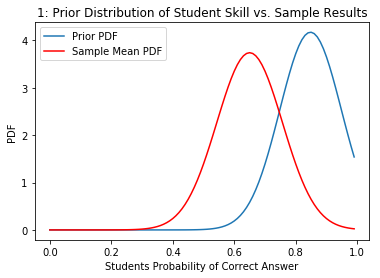

In [3]:
# create timeseries x evenly spaced with 100 values between 0 and 1
x = np.linspace(0, 1, num=nx+1)
x = np.delete(x, -1)

# Bayesian prior distribution based on past students
prior_pdf = st.norm.pdf(x, mu, sigma)
for i in range(len(prior_pdf)):
    prior_pdf[i] = prior_pdf[i] / ((x[1] - x[0])*sum(prior_pdf))
prior_cdf = (x[1] - x[0])*np.cumsum(prior_pdf)

# non-Bayesian sample mean and standard deviation based on quizzes
# using sample size of 20, where each question is independent.
# this is expected p, number of successes divided by n
p_bar = sum(c) / (m*n)

ones_and_zeros = []
for i in range(sum(c)):
    ones_and_zeros.append(1)
for j in range(m*n-sum(c)):
    ones_and_zeros.append(0)
s_bar = stats.stdev(ones_and_zeros)
# Note that s_bar determines the standard deviation in the number of right
# answers, not the standard deviation of the probability of success.

# Over n trials, the variance of the number of successes/failures 
# is measured by
# sigma^2 = n*p*(1-p)
# and the variance of the probability of success is the above variance
# divided by n^2
# so sigma_p= sqrt(sigma^2/n^2) = sqrt(p*(1-p)/n) % as written below
nonBayes_pdf = st.norm.pdf(x, p_bar, np.sqrt(p_bar*(1-p_bar)/(m*n)))
nonBayes_cdf = (x[1] - x[0]) * np.cumsum(nonBayes_pdf)

# Plot
plt.figure()
plt.plot(x, prior_pdf, label = 'Prior PDF')
plt.plot(x, nonBayes_pdf, color='red', label='Sample Mean PDF')
plt.xlabel('Student''s Probability of Correct Answer')
plt.ylabel('PDF')
plt.legend(loc='best')
plt.title('1: Prior Distribution of Student Skill vs. Sample Results');

#### So, above we see two different estimates of information.  The prior PDF is based on how students in general do in the class as a whole.  The second, based on two quizzes, is based only on the student's performance on two quizzes.  Bayes theorem gives us a way to combine these two pieces of information.

In [4]:
# information in just the first test
likelihood = []
for i in range(0, nx):
    # calculate likelihood of test score given student's "true" fraction correct
    likelihood.append(st.binom.pmf(c[0], n, x[i]))
    # Note, this is P(B|A)

In [5]:
# Use that information to update the prior for a new, posterior pdf
# Calculate the posterior likelihood using Bayes' Theorem

post_pdf1 = []
for j in range(0, nx-1):
    post_pdf1.append(likelihood[j] * prior_pdf[j])
    # Note that I'm not normalizing yet. I'm calculating P(B|A)*P(A)

In [6]:
# Now consider each test in sequence (some of this is repeat from above; 
# above was for illustration)

post_pdf = np.empty([m+1,nx])
post_cdf = np.empty([m+1,nx])
post_pdf.fill(np.nan)
post_cdf.fill(np.nan)

post_pdf[0] = prior_pdf   # This is P(A) for all x
post_cdf[0] = prior_cdf

likelihood = np.empty([m,nx])
likelihood.fill(np.nan)

for i in range(0, m):   # loop through each test
    for j in range(0, nx):   # loop through each incremental fraction correct
        # calculate likelihood of test score given students' "true" fraction correct
        likelihood[i,j] = st.binom.pmf(c[i], n, x[j])
        #now calculate the posterior likelihood using Bayes' Theorem
        post_pdf[i+1,j] = likelihood[i,j] * post_pdf[i,j]

        
    # normalize so that area under curve is 1 and then calculate CDF
    post_pdf[i + 1] = post_pdf[i + 1]/((x[1] - x[0])*np.nansum(post_pdf[i + 1]))
    # right here we are normalizing by P(B) which is SUM of P(B|A)*P(A)
    # over all values of A, applying the chain rule
    post_cdf[i + 1] = (x[2] - x[1])*np.cumsum(post_pdf[i + 1])

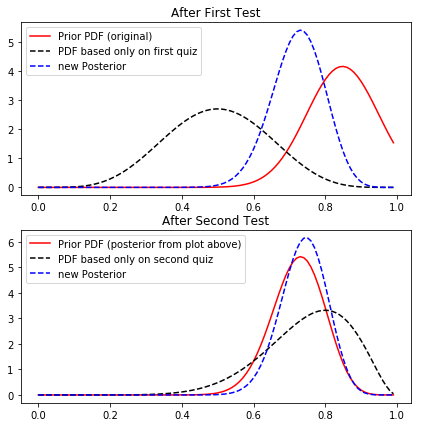

In [7]:
# Make the plot comparing the first and second steps

y_likelihood = np.zeros_like(likelihood)
for i in range (likelihood.shape[0]):
    for j in range(likelihood.shape[1]):
        y_likelihood[i,j] = likelihood[i,j] / (np.sum(likelihood[i]) * (x[1] - x[0]))

        
f, ax = plt.subplots(2,1,figsize=(7,7))
ax[0].plot(x, post_pdf[0], 'r', label='Prior PDF (original)')        
ax[0].plot(x, y_likelihood[0], 'k--', label='PDF based only on first quiz')    
ax[0].plot(x, post_pdf[1], 'b--', label='new Posterior')
ax[0].set_title('After First Test')
ax[0].legend(loc='best')

ax[1].plot(x, post_pdf[1], 'r', label='Prior PDF (posterior from plot above)')    
ax[1].plot(x, y_likelihood[1], 'k--', label='PDF based only on second quiz')
ax[1].plot(x, post_pdf[2], 'b--', label='new Posterior')
ax[1].set_title('After Second Test')
ax[1].legend(loc='best');

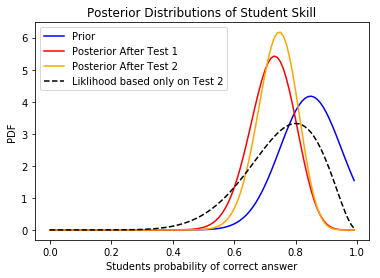

In [8]:
# plot posterior distributions

plt.figure()
plt.plot(x, post_pdf[0],'b', label='Prior')
plt.plot(x, post_pdf[1], 'r', label='Posterior After Test 1')
plt.plot(x, post_pdf[2], 'orange', label='Posterior After Test 2')
plt.plot(x, y_likelihood[1], 'k--', label='Liklihood based only on Test 2')
plt.xlabel('Student''s probability of correct answer')
plt.ylabel('PDF')
plt.legend(loc='best')
plt.title('Posterior Distributions of Student Skill');

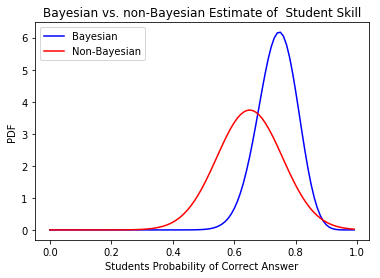

In [9]:
# Plot posterior versus non-Bayesian estimate

plt.figure()
plt.plot(x, post_pdf[m], 'b', label='Bayesian')
plt.plot(x, nonBayes_pdf, 'r', label = 'Non-Bayesian')
plt.title('Bayesian vs. non-Bayesian Estimate of  Student Skill')
plt.xlabel('Student''s Probability of Correct Answer')
plt.ylabel('PDF')
plt.legend(loc='best')

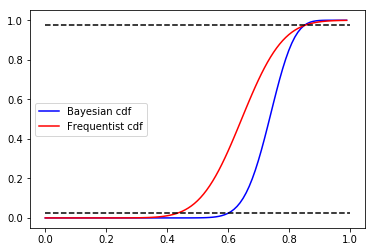

In [10]:
# Look for 95% Confidence intervals

plt.figure()
plt.plot(x, post_cdf[2], 'b', label='Bayesian cdf')
plt.plot(x, nonBayes_cdf, 'r',label='Frequentist cdf')
plt.plot([0,1],[0.025, 0.025], 'k--')
plt.plot([0,1],[0.975, 0.975], 'k--')
plt.legend(loc='best')

### How do they differ?
We can see that the frequentist approach says the student's score would be 43% to 86%, while the Bayesian approach says the student's score would be 60% to 85% --  The Bayesian approach is both more optimistic and more confident.  This may be because later exams are easier in the class than the first two, or most students figure out the testing process as the quarter goes along.